In [1]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy
import seaborn as sns
import sys
import warnings

from scipy import stats

In [4]:
df1 = pd.read_csv('/Users/stevenang/DataspellProjects/DataProcessing/processed_data/combined.csv')

columns_to_keep = ['subject_id', 'gender', 'age', 'diagnosis', 'site_name']
selected_data = df1[columns_to_keep]

print(selected_data.head())

    subject_id  gender   age diagnosis site_name
0  sub-0023001     0.0  9.33   Control      OHSU
1  sub-0010011     1.0  9.16      ADHD       NYU
2  sub-2427434     1.0  8.08   Control      OHSU
3  sub-2230510     0.0  9.17      ADHD       NYU
4  sub-0023006     1.0  9.25   Control      OHSU


In [6]:
def analyze_data_statistics(df):
    """
    Generate comprehensive statistics for gender, age, and diagnosis per site

    Parameters:
    df (pandas.DataFrame): DataFrame with columns: subject_id, gender, age, diagnosis, site_name

    Returns:
    dict: Dictionary containing all statistics
    """

    print("="*60)
    print("DATA STATISTICS SUMMARY")
    print("="*60)

    # Overall summary
    print(f"\nTotal Records: {len(df)}")
    print(f"Total Sites: {df['site_name'].nunique()}")
    print(f"Sites: {', '.join(df['site_name'].unique())}")

    # 1. Gender distribution per site
    print("\n" + "="*50)
    print("1. GENDER DISTRIBUTION PER SITE")
    print("="*50)

    gender_site = pd.crosstab(df['site_name'], df['gender'], margins=True)
    gender_site.columns = ['Male (0)', 'Female (1)', 'Total']
    print(gender_site)

    # Gender percentages per site
    print("\nGender Percentages per Site:")
    for site in df['site_name'].unique():
        site_data = df[df['site_name'] == site]
        male_count = (site_data['gender'] == 0).sum()
        female_count = (site_data['gender'] == 1).sum()
        total = len(site_data)

        male_pct = (male_count / total) * 100
        female_pct = (female_count / total) * 100

        print(f"{site}: Male {male_pct:.1f}% ({male_count}), Female {female_pct:.1f}% ({female_count})")

    # 2. Age statistics per site
    print("\n" + "="*50)
    print("2. AGE STATISTICS PER SITE")
    print("="*50)

    age_stats = df.groupby('site_name')['age'].agg([
        'count', 'mean', 'std', 'min', 'max', 'median'
    ]).round(2)
    age_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max', 'Median']
    print(age_stats)

    # Age distribution by gender per site
    print("\nAge Statistics by Gender per Site:")
    for site in df['site_name'].unique():
        print(f"\n{site}:")
        site_data = df[df['site_name'] == site]

        male_ages = site_data[site_data['gender'] == 0]['age']
        female_ages = site_data[site_data['gender'] == 1]['age']

        if len(male_ages) > 0:
            print(f"  Male - Mean: {male_ages.mean():.2f}, Std: {male_ages.std():.2f}, Range: {male_ages.min():.2f}-{male_ages.max():.2f}")

        if len(female_ages) > 0:
            print(f"  Female - Mean: {female_ages.mean():.2f}, Std: {female_ages.std():.2f}, Range: {female_ages.min():.2f}-{female_ages.max():.2f}")

    # 3. Diagnosis distribution per site
    print("\n" + "="*50)
    print("3. DIAGNOSIS DISTRIBUTION PER SITE")
    print("="*50)

    diagnosis_site = pd.crosstab(df['site_name'], df['diagnosis'], margins=True)
    print(diagnosis_site)

    # Diagnosis percentages per site
    print("\nDiagnosis Percentages per Site:")
    for site in df['site_name'].unique():
        site_data = df[df['site_name'] == site]
        diagnosis_counts = site_data['diagnosis'].value_counts()
        total = len(site_data)

        print(f"\n{site}:")
        for diagnosis, count in diagnosis_counts.items():
            percentage = (count / total) * 100
            print(f"  {diagnosis}: {percentage:.1f}% ({count})")

    # 4. Combined statistics: Gender x Diagnosis per Site
    print("\n" + "="*50)
    print("4. GENDER × DIAGNOSIS DISTRIBUTION PER SITE")
    print("="*50)

    for site in df['site_name'].unique():
        print(f"\n{site}:")
        site_data = df[df['site_name'] == site]

        combined_stats = pd.crosstab(
            site_data['gender'].map({0: 'Male', 1: 'Female'}),
            site_data['diagnosis']
        )
        print(combined_stats)

        # Show percentages
        print("Percentages:")
        total = len(site_data)
        for gender_val, gender_label in [(0, 'Male'), (1, 'Female')]:
            for diagnosis in site_data['diagnosis'].unique():
                count = len(site_data[(site_data['gender'] == gender_val) &
                                      (site_data['diagnosis'] == diagnosis)])
                pct = (count / total) * 100
                print(f"  {gender_label} + {diagnosis}: {pct:.1f}% ({count})")

    # 5. Age by diagnosis per site
    print("\n" + "="*50)
    print("5. AGE STATISTICS BY DIAGNOSIS PER SITE")
    print("="*50)

    for site in df['site_name'].unique():
        print(f"\n{site}:")
        site_data = df[df['site_name'] == site]

        age_by_diagnosis = site_data.groupby('diagnosis')['age'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        age_by_diagnosis.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max']
        print(age_by_diagnosis)

    return {
        'gender_site': gender_site,
        'age_stats': age_stats,
        'diagnosis_site': diagnosis_site
    }

In [7]:
data = analyze_data_statistics(selected_data)

DATA STATISTICS SUMMARY

Total Records: 434
Total Sites: 7
Sites: OHSU, NYU, Peking_2, Peking_3, NeuroImage, Pittsburgh, WashU

1. GENDER DISTRIBUTION PER SITE
            Male (0)  Female (1)  Total
site_name                              
NYU              120          57    177
NeuroImage        29          16     45
OHSU              27          28     55
Peking_2          33           1     34
Peking_3          24           0     24
Pittsburgh        38          26     64
WashU             19          16     35
All              290         144    434

Gender Percentages per Site:
OHSU: Male 49.1% (27), Female 50.9% (28)
NYU: Male 67.8% (120), Female 32.2% (57)
Peking_2: Male 97.1% (33), Female 2.9% (1)
Peking_3: Male 100.0% (24), Female 0.0% (0)
NeuroImage: Male 64.4% (29), Female 35.6% (16)
Pittsburgh: Male 59.4% (38), Female 40.6% (26)
WashU: Male 54.3% (19), Female 45.7% (16)

2. AGE STATISTICS PER SITE
            Count   Mean  Std Dev    Min    Max  Median
site_name            

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set academic style
plt.style.use('default')
sns.set_palette("Set2")

def create_academic_figures(df, save_figs=True, dpi=300):
    """
    Create publication-ready figures for academic papers

    Parameters:
    df (pandas.DataFrame): Your dataset
    save_figs (bool): Whether to save figures as high-resolution files
    dpi (int): Resolution for saved figures
    """

    # Set consistent figure parameters for academic publishing
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'figure.titlesize': 16,
        'font.family': 'Arial'
    })

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))

    # Figure 1A: Demographics Overview - Stacked Bar Chart
    ax1 = plt.subplot(2, 3, 1)

    # Create demographic summary
    demo_data = []
    for site in df['site_name'].unique():
        site_data = df[df['site_name'] == site]
        for diag in site_data['diagnosis'].unique():
            for gender in [0, 1]:
                count = len(site_data[(site_data['diagnosis'] == diag) & (site_data['gender'] == gender)])
                demo_data.append({
                    'Site': site,
                    'Diagnosis': diag,
                    'Gender': 'Male' if gender == 0 else 'Female',
                    'Count': count
                })

    demo_df = pd.DataFrame(demo_data)

    # Pivot for stacked bar chart
    pivot_data = demo_df.pivot_table(index=['Site', 'Diagnosis'], columns='Gender', values='Count', fill_value=0)

    # Create stacked bar chart
    pivot_data.plot(kind='bar', stacked=True, ax=ax1, color=['#2E86AB', '#A23B72'], width=0.7)
    ax1.set_title('A. Participant Demographics by Site and Diagnosis', fontweight='bold', pad=20)
    ax1.set_xlabel('Site - Diagnosis')
    ax1.set_ylabel('Number of Participants')
    ax1.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)

    # Figure 1B: Age Distribution by Site
    ax2 = plt.subplot(2, 3, 2)

    # Box plot for age distribution
    box_data = []
    labels = []
    for site in sorted(df['site_name'].unique()):
        site_ages = df[df['site_name'] == site]['age']
        box_data.append(site_ages)
        labels.append(f"{site}\n(n={len(site_ages)})")

    bp = ax2.boxplot(box_data, labels=labels, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))

    ax2.set_title('B. Age Distribution by Site', fontweight='bold', pad=20)
    ax2.set_ylabel('Age (years)')
    ax2.set_xlabel('Site')
    ax2.grid(True, alpha=0.3)

    # Figure 1C: Age Distribution by Diagnosis
    ax3 = plt.subplot(2, 3, 3)

    # Violin plot showing age distributions
    diagnosis_order = sorted(df['diagnosis'].unique())
    sns.violinplot(data=df, x='diagnosis', y='age', ax=ax3, palette='Set2')

    # Add individual points
    sns.stripplot(data=df, x='diagnosis', y='age', ax=ax3, size=3, alpha=0.6, color='black')

    ax3.set_title('C. Age Distribution by Diagnosis', fontweight='bold', pad=20)
    ax3.set_xlabel('Diagnosis')
    ax3.set_ylabel('Age (years)')

    # Add sample sizes
    for i, diag in enumerate(diagnosis_order):
        n = len(df[df['diagnosis'] == diag])
        ax3.text(i, ax3.get_ylim()[0], f'n={n}', ha='center', va='top', fontweight='bold')

    # Figure 1D: Gender Distribution Pie Charts
    ax4 = plt.subplot(2, 3, 4)

    # Overall gender distribution
    gender_counts = df['gender'].map({0: 'Male', 1: 'Female'}).value_counts()
    colors = ['#2E86AB', '#A23B72']

    wedges, texts, autotexts = ax4.pie(gender_counts.values, labels=gender_counts.index,
                                       autopct='%1.1f%%', colors=colors, startangle=90)

    ax4.set_title('D. Overall Gender Distribution', fontweight='bold', pad=20)

    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # Figure 1E: Sample Size Summary Table
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')

    # Create summary table
    summary_data = []
    for site in sorted(df['site_name'].unique()):
        site_data = df[df['site_name'] == site]

        total = len(site_data)
        male = len(site_data[site_data['gender'] == 0])
        female = len(site_data[site_data['gender'] == 1])
        control = len(site_data[site_data['diagnosis'] == 'Control'])
        adhd = len(site_data[site_data['diagnosis'] == 'ADHD'])
        mean_age = site_data['age'].mean()
        std_age = site_data['age'].std()

        summary_data.append([site, total, male, female, control, adhd, f"{mean_age:.1f}±{std_age:.1f}"])

    # Add total row
    total_all = len(df)
    male_all = len(df[df['gender'] == 0])
    female_all = len(df[df['gender'] == 1])
    control_all = len(df[df['diagnosis'] == 'Control'])
    adhd_all = len(df[df['diagnosis'] == 'ADHD'])
    mean_age_all = df['age'].mean()
    std_age_all = df['age'].std()

    summary_data.append(['Total', total_all, male_all, female_all, control_all, adhd_all,
                         f"{mean_age_all:.1f}±{std_age_all:.1f}"])

    # Create table
    columns = ['Site', 'Total', 'Male', 'Female', 'Control', 'ADHD', 'Age (M±SD)']

    table = ax5.table(cellText=summary_data, colLabels=columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style the table
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#E6E6FA')
        table[(0, i)].set_text_props(weight='bold')

    # Style the total row
    for i in range(len(columns)):
        table[(len(summary_data), i)].set_facecolor('#F0F0F0')
        table[(len(summary_data), i)].set_text_props(weight='bold')

    ax5.set_title('E. Sample Characteristics Summary', fontweight='bold', pad=20)

    # Figure 1F: Age vs Gender Scatter by Site
    ax6 = plt.subplot(2, 3, 6)

    sites = df['site_name'].unique()
    colors_scatter = plt.cm.Set1(np.linspace(0, 1, len(sites)))

    for i, site in enumerate(sites):
        site_data = df[df['site_name'] == site]

        # Male data
        male_data = site_data[site_data['gender'] == 0]
        ax6.scatter(male_data['age'], [i-0.1]*len(male_data),
                    alpha=0.7, s=60, marker='s', color=colors_scatter[i],
                    label=f'{site} Male' if i == 0 else "")

        # Female data
        female_data = site_data[site_data['gender'] == 1]
        ax6.scatter(female_data['age'], [i+0.1]*len(female_data),
                    alpha=0.7, s=60, marker='o', color=colors_scatter[i],
                    label=f'{site} Female' if i == 0 else "")

    ax6.set_title('F. Age Distribution by Site and Gender', fontweight='bold', pad=20)
    ax6.set_xlabel('Age (years)')
    ax6.set_ylabel('Site')
    ax6.set_yticks(range(len(sites)))
    ax6.set_yticklabels(sites)
    ax6.grid(True, alpha=0.3)
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    if save_figs:
        plt.savefig('Figure1_Demographics.png', dpi=dpi, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.savefig('Figure1_Demographics.pdf', bbox_inches='tight',
                    facecolor='white', edgecolor='none')

    plt.show()

    # Create a second figure focusing on statistical comparisons
    create_statistical_figure(df, save_figs, dpi)

def create_statistical_figure(df, save_figs=True, dpi=300):
    """Create a second figure with statistical comparisons"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Figure 2A: Age comparison between diagnoses with statistical test
    from scipy import stats

    control_ages = df[df['diagnosis'] == 'Control']['age']
    adhd_ages = df[df['diagnosis'] == 'ADHD']['age']

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(control_ages, adhd_ages)

    # Box plot with statistical annotation
    bp1 = ax1.boxplot([control_ages, adhd_ages],
                      labels=['Control', 'ADHD'],
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7))

    ax1.set_title('A. Age Comparison by Diagnosis', fontweight='bold', pad=20)
    ax1.set_ylabel('Age (years)')
    ax1.set_xlabel('Diagnosis')

    # Add statistical annotation
    y_max = max(df['age']) + 0.5
    ax1.plot([1, 2], [y_max, y_max], 'k-', linewidth=1)
    ax1.text(1.5, y_max + 0.1, f'p = {p_value:.3f}', ha='center', fontweight='bold')

    # Add sample sizes and statistics
    ax1.text(1, control_ages.min() - 0.3,
             f'n = {len(control_ages)}\nM = {control_ages.mean():.2f}\nSD = {control_ages.std():.2f}',
             ha='center', va='top', fontsize=10)
    ax1.text(2, adhd_ages.min() - 0.3,
             f'n = {len(adhd_ages)}\nM = {adhd_ages.mean():.2f}\nSD = {adhd_ages.std():.2f}',
             ha='center', va='top', fontsize=10)

    # Figure 2B: Gender distribution by site with chi-square test
    contingency_table = pd.crosstab(df['site_name'], df['gender'])
    chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)

    # Grouped bar chart
    x = np.arange(len(contingency_table.index))
    width = 0.35

    ax2.bar(x - width/2, contingency_table[0], width, label='Male', color='#2E86AB', alpha=0.8)
    ax2.bar(x + width/2, contingency_table[1], width, label='Female', color='#A23B72', alpha=0.8)

    ax2.set_title('B. Gender Distribution by Site', fontweight='bold', pad=20)
    ax2.set_xlabel('Site')
    ax2.set_ylabel('Number of Participants')
    ax2.set_xticks(x)
    ax2.set_xticklabels(contingency_table.index)
    ax2.legend()
    ax2.text(0.5, max(contingency_table.max()) * 0.9,
             f'χ² = {chi2:.3f}, p = {p_chi2:.3f}',
             ha='center', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

    # Figure 2C: Age histogram by diagnosis
    bins = np.arange(df['age'].min(), df['age'].max() + 0.5, 0.5)

    ax3.hist(control_ages, bins=bins, alpha=0.7, label='Control', color='skyblue', density=True)
    ax3.hist(adhd_ages, bins=bins, alpha=0.7, label='ADHD', color='lightcoral', density=True)

    ax3.set_title('C. Age Distribution Density by Diagnosis', fontweight='bold', pad=20)
    ax3.set_xlabel('Age (years)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Figure 2D: Summary statistics heatmap
    # Create summary statistics for heatmap
    heatmap_data = []
    for site in sorted(df['site_name'].unique()):
        site_data = df[df['site_name'] == site]

        row = [
            len(site_data),  # Total N
            len(site_data[site_data['gender'] == 1]) / len(site_data) * 100,  # % Female
            site_data['age'].mean(),  # Mean age
            len(site_data[site_data['diagnosis'] == 'ADHD']) / len(site_data) * 100  # % ADHD
        ]
        heatmap_data.append(row)

    heatmap_df = pd.DataFrame(heatmap_data,
                              index=sorted(df['site_name'].unique()),
                              columns=['Total N', '% Female', 'Mean Age', '% ADHD'])

    # Normalize data for heatmap (each column separately)
    heatmap_normalized = heatmap_df.copy()
    for col in heatmap_df.columns:
        col_min, col_max = heatmap_df[col].min(), heatmap_df[col].max()
        heatmap_normalized[col] = (heatmap_df[col] - col_min) / (col_max - col_min)

    im = ax4.imshow(heatmap_normalized.values, cmap='RdYlBu_r', aspect='auto')

    # Add text annotations
    for i in range(len(heatmap_df.index)):
        for j in range(len(heatmap_df.columns)):
            value = heatmap_df.iloc[i, j]
            if j == 0:  # Total N
                text = f'{value:.0f}'
            elif j in [1, 3]:  # Percentages
                text = f'{value:.1f}%'
            else:  # Mean age
                text = f'{value:.1f}'
            ax4.text(j, i, text, ha='center', va='center', fontweight='bold')

    ax4.set_xticks(range(len(heatmap_df.columns)))
    ax4.set_xticklabels(heatmap_df.columns)
    ax4.set_yticks(range(len(heatmap_df.index)))
    ax4.set_yticklabels(heatmap_df.index)
    ax4.set_title('D. Site Characteristics Heatmap', fontweight='bold', pad=20)

    plt.tight_layout()

    if save_figs:
        plt.savefig('Figure2_Statistical_Analysis.png', dpi=dpi, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.savefig('Figure2_Statistical_Analysis.pdf', bbox_inches='tight',
                    facecolor='white', edgecolor='none')

    plt.show()

# Function to generate publication-ready table
def create_publication_table(df):
    """Create a publication-ready demographic table"""

    print("\n" + "="*80)
    print("TABLE 1: PARTICIPANT CHARACTERISTICS")
    print("="*80)

    # Create comprehensive table
    table_data = []

    # Overall statistics
    total_n = len(df)
    male_n = len(df[df['gender'] == 0])
    female_n = len(df[df['gender'] == 1])
    control_n = len(df[df['diagnosis'] == 'Control'])
    adhd_n = len(df[df['diagnosis'] == 'ADHD'])
    age_mean = df['age'].mean()
    age_std = df['age'].std()
    age_range = f"{df['age'].min():.1f}-{df['age'].max():.1f}"

    table_data.append(['Total Sample', f'{total_n}', f'{male_n} ({male_n/total_n*100:.1f}%)',
                       f'{female_n} ({female_n/total_n*100:.1f}%)',
                       f'{age_mean:.2f} ± {age_std:.2f}', age_range])

    # By site
    for site in sorted(df['site_name'].unique()):
        site_data = df[df['site_name'] == site]
        site_n = len(site_data)
        site_male = len(site_data[site_data['gender'] == 0])
        site_female = len(site_data[site_data['gender'] == 1])
        site_age_mean = site_data['age'].mean()
        site_age_std = site_data['age'].std()
        site_age_range = f"{site_data['age'].min():.1f}-{site_data['age'].max():.1f}"

        table_data.append([f'  {site}', f'{site_n}', f'{site_male} ({site_male/site_n*100:.1f}%)',
                           f'{site_female} ({site_female/site_n*100:.1f}%)',
                           f'{site_age_mean:.2f} ± {site_age_std:.2f}', site_age_range])

    # By diagnosis
    table_data.append(['', '', '', '', '', ''])  # Empty row
    table_data.append(['By Diagnosis', '', '', '', '', ''])

    for diag in sorted(df['diagnosis'].unique()):
        diag_data = df[df['diagnosis'] == diag]
        diag_n = len(diag_data)
        diag_male = len(diag_data[diag_data['gender'] == 0])
        diag_female = len(diag_data[diag_data['gender'] == 1])
        diag_age_mean = diag_data['age'].mean()
        diag_age_std = diag_data['age'].std()
        diag_age_range = f"{diag_data['age'].min():.1f}-{diag_data['age'].max():.1f}"

        table_data.append([f'  {diag}', f'{diag_n}', f'{diag_male} ({diag_male/diag_n*100:.1f}%)',
                           f'{diag_female} ({diag_female/diag_n*100:.1f}%)',
                           f'{diag_age_mean:.2f} ± {diag_age_std:.2f}', diag_age_range])

    # Print formatted table
    headers = ['Group', 'N', 'Male', 'Female', 'Age (M ± SD)', 'Age Range']

    # Calculate column widths
    col_widths = [max(len(str(row[i])) for row in [headers] + table_data) + 2 for i in range(len(headers))]

    # Print header
    header_line = '|'.join(f'{headers[i]:^{col_widths[i]}}' for i in range(len(headers)))
    print(header_line)
    print('-' * len(header_line))

    # Print data rows
    for row in table_data:
        if all(cell == '' for cell in row[1:]):  # Empty row
            print()
        else:
            data_line = '|'.join(f'{row[i]:^{col_widths[i]}}' for i in range(len(row)))
            print(data_line)

    print("\nNote: Values are presented as n (%) for categorical variables and M ± SD for continuous variables.")


Creating academic figures...


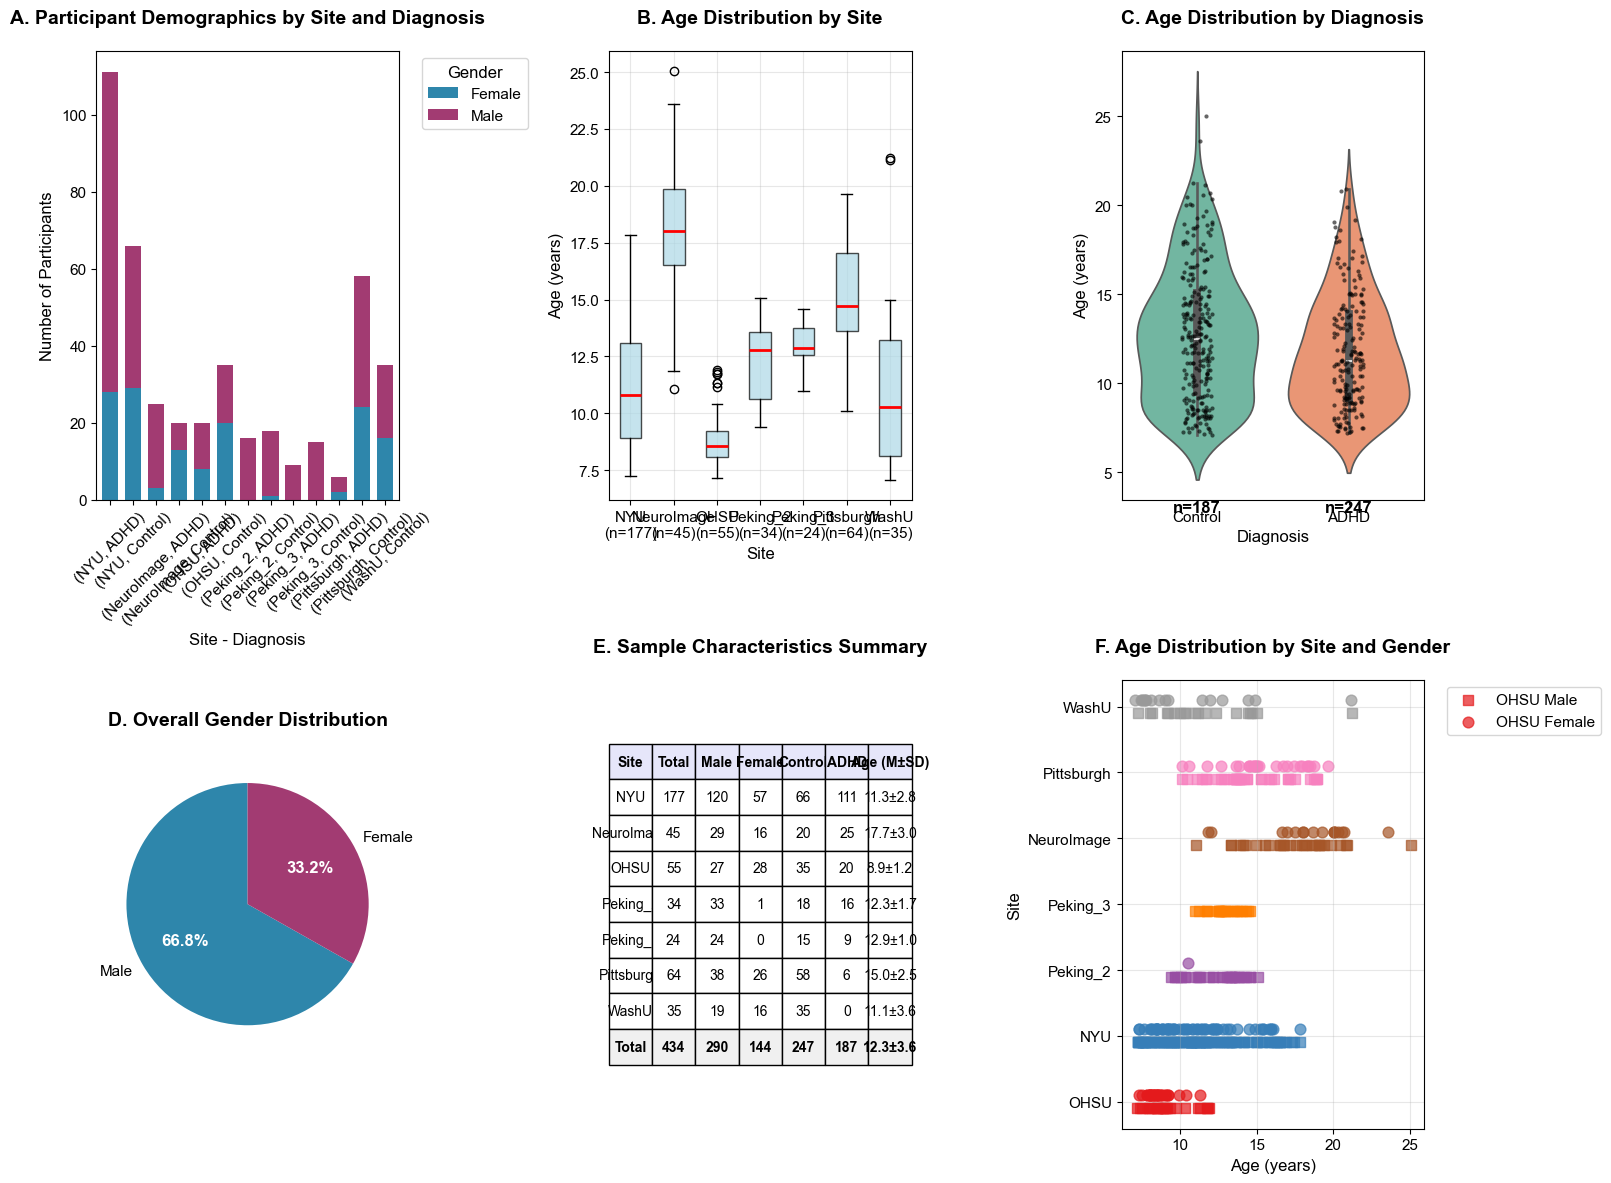

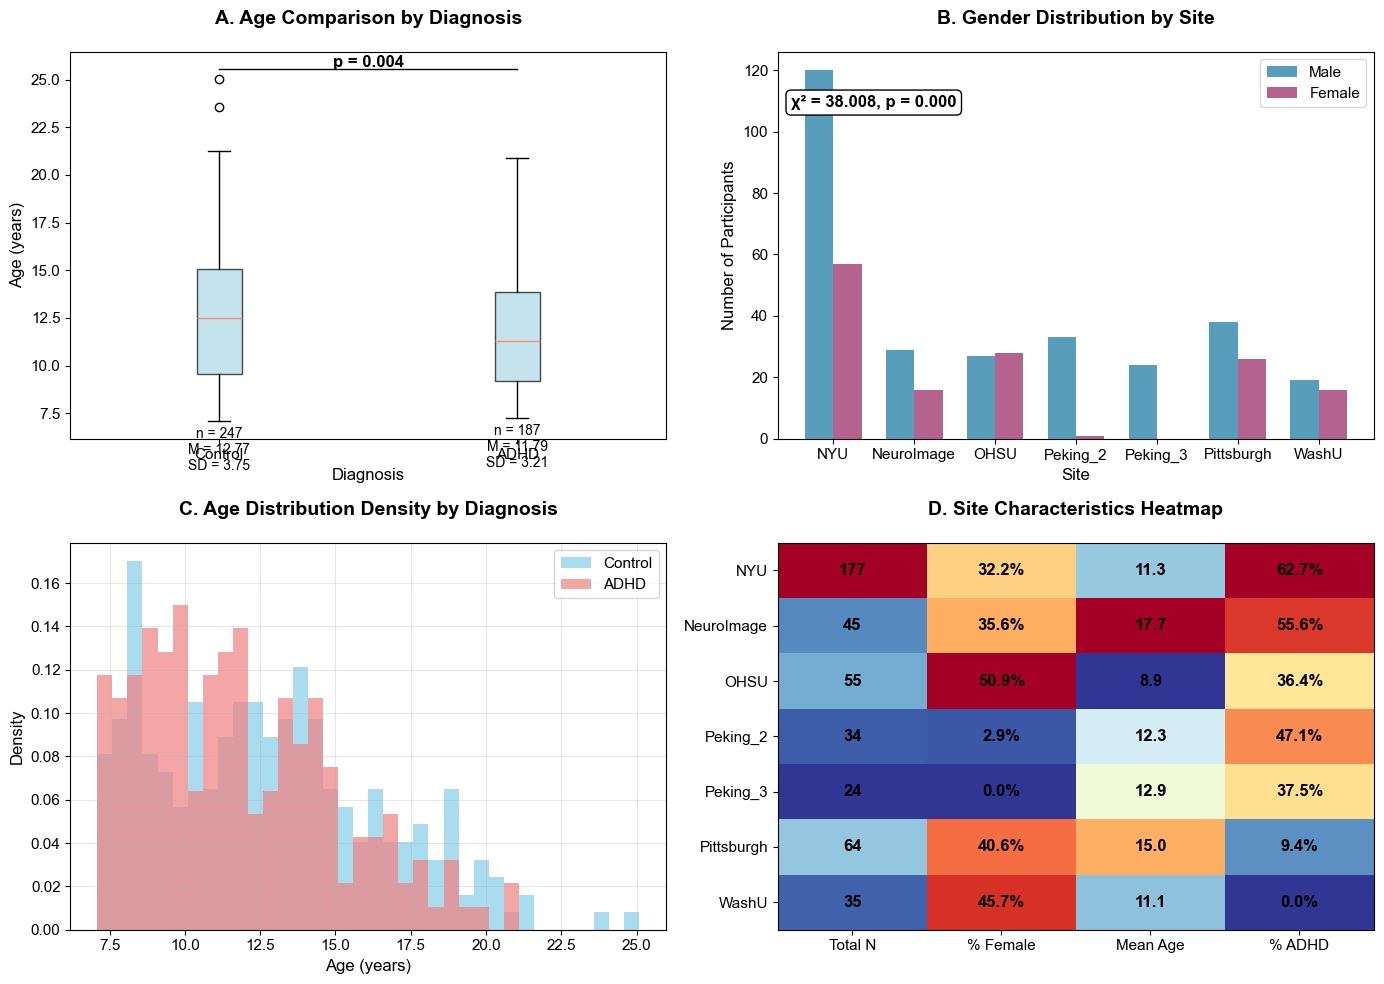

In [9]:
print("Creating academic figures...")
create_academic_figures(selected_data, save_figs=True)

In [10]:
print("Creating publication table...")
create_publication_table(selected_data)

Creating publication table...

TABLE 1: PARTICIPANT CHARACTERISTICS
    Group     |  N  |    Male     |   Female    | Age (M ± SD) | Age Range 
---------------------------------------------------------------------------
 Total Sample | 434 | 290 (66.8%) | 144 (33.2%) | 12.35 ± 3.56 | 7.1-25.0  
      NYU     | 177 | 120 (67.8%) | 57 (32.2%)  | 11.26 ± 2.80 | 7.2-17.9  
   NeuroImage | 45  | 29 (64.4%)  | 16 (35.6%)  | 17.72 ± 2.96 | 11.1-25.0 
      OHSU    | 55  | 27 (49.1%)  | 28 (50.9%)  | 8.93 ± 1.22  | 7.2-11.9  
    Peking_2  | 34  | 33 (97.1%)  |  1 (2.9%)   | 12.28 ± 1.71 | 9.4-15.1  
    Peking_3  | 24  | 24 (100.0%) |  0 (0.0%)   | 12.94 ± 0.99 | 11.0-14.6 
   Pittsburgh | 64  | 38 (59.4%)  | 26 (40.6%)  | 15.02 ± 2.53 | 10.1-19.7 
     WashU    | 35  | 19 (54.3%)  | 16 (45.7%)  | 11.11 ± 3.58 | 7.1-21.2  


      ADHD    | 187 | 146 (78.1%) | 41 (21.9%)  | 11.79 ± 3.21 | 7.2-20.9  
    Control   | 247 | 144 (58.3%) | 103 (41.7%) | 12.77 ± 3.75 | 7.1-25.0  

Note: Values are 